# Desafio 1 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Configurações

In [2]:
seed: int = 0
data_path: Path = Path("../desafio/assets/data/")

## Dados

### Junção dos datasets

In [3]:
accounts = pd.read_csv(data_path / "ACCOUNTS.csv", index_col="ID")
account_cols = list(accounts.columns)
print(account_cols)

['CHECKING_BALANCE', 'CREDIT_HISTORY', 'EXISTING_SAVINGS', 'EXISTING_CREDITS_COUNT']


In [4]:
demographics = pd.read_csv(data_path / "DEMOGRAPHICS.csv", index_col="ID")
demographic_cols = list(demographics.columns)
print(demographic_cols)

['SEX', 'AGE', 'JOB_TYPE', 'DEPENDENTS', 'TELEPHONE', 'FOREIGN_WORKER', 'EMPLOYMENT_DURATION', 'PROPERTY', 'HOUSING', 'CURRENT_RESIDENCE_DURATION']


In [5]:
loans = pd.read_csv(data_path / "LOANS.csv", index_col="ID")
loan_cols = list(loans.columns)
print(loan_cols)

['PAYMENT_TERM', 'INSTALLMENT_PLANS', 'INSTALLMENT_PERCENT', 'LOAN_PURPOSE', 'LOAN_AMOUNT', 'OTHERS_ON_LOAN', 'ALLOW']


In [6]:
df_all = pd.concat([accounts, demographics, loans], axis=1)

### Informações gerais

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 98 to 1320082
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CHECKING_BALANCE            2467 non-null   object 
 1   CREDIT_HISTORY              2462 non-null   object 
 2   EXISTING_SAVINGS            2467 non-null   object 
 3   EXISTING_CREDITS_COUNT      2463 non-null   float64
 4   SEX                         3920 non-null   object 
 5   AGE                         3918 non-null   float64
 6   JOB_TYPE                    3910 non-null   float64
 7   DEPENDENTS                  3915 non-null   float64
 8   TELEPHONE                   3915 non-null   float64
 9   FOREIGN_WORKER              3909 non-null   float64
 10  EMPLOYMENT_DURATION         3923 non-null   float64
 11  PROPERTY                    3918 non-null   object 
 12  HOUSING                     3912 non-null   object 
 13  CURRENT_RESIDENCE_DURATION  3

- A maioria das variáveis (colunas) são numéricas, mas há algumas categóricas.
- Com exceção da variável que identifica cada cliente (o índice `ID`) e da variável de destino (`ALLOW`), todas têm dados faltantes (nulos).

### Divisão dos dados entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [8]:
test_size = 500
target = "ALLOW"
df_train, df_test = train_test_split(df_all, test_size=test_size, random_state=seed, stratify=df_all[[target]])
print(f'Dimensões dos dados de treino: {df_train.shape}')
print(f'Dimensões dos dados de teste: {df_test.shape}')

Dimensões dos dados de treino: (3499, 21)
Dimensões dos dados de teste: (500, 21)


### Variável destino

A variável destino para este desafio é a `ALLOW`, significando se um empréstimo deverá ser permitido ou não, baseado nas informações dadas. Vamos dar uma olhada em como está a distribuição dessa variável

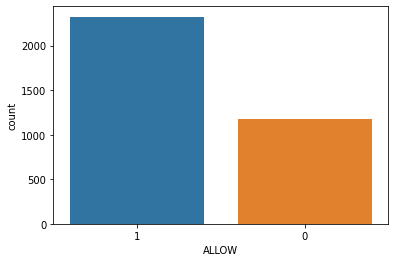

In [9]:
risk_plot = sns.countplot(
    data=df_train, x=target, order=df_train[target].value_counts().index
)
plt.show()


In [10]:
# list(set(df_all.columns) - set(target))

### Dados de exemplo

In [11]:
with pd.option_context("display.max_columns", None):
    display(df_train.sample(10, random_state=seed))

,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW
ID,,,,,,,,,,,,,,,,,,,,,
443445,NaN,NaN,NaN,NaN,M,24.0,3.0,1.0,0.0,1.0,0.0,REAL_ESTATE,RENT,2.0,270.0,NONE,1.0,CAR_NEW,250.0,NONE,1
1208610,NaN,NaN,NaN,NaN,M,35.0,3.0,2.0,1.0,1.0,6.0,UNKNOWN,OWN,3.0,1170.0,NONE,3.0,APPLIANCES,4545.0,NONE,0
887509,NO_CHECKING,CREDITS_PAID_TO_DATE,980.41,1.0,M,53.0,3.0,1.0,1.0,1.0,7.0,SAVINGS_INSURANCE,OWN,4.0,630.0,NONE,4.0,FURNITURE,1903.0,NONE,1
1291443,144.51,PRIOR_PAYMENTS_DELAYED,53.87,2.0,M,35.0,1.0,1.0,0.0,1.0,4.0,CAR_OTHER,OWN,4.0,465.0,STORES,3.0,FURNITURE,1931.0,NONE,1
76618,NO_CHECKING,CREDITS_PAID_TO_DATE,201.44,1.0,M,34.0,2.0,1.0,0.0,1.0,4.0,SAVINGS_INSURANCE,RENT,4.0,510.0,NONE,3.0,CAR_NEW,2720.0,NONE,1
1206978,NO_CHECKING,OUTSTANDING_CREDIT,829.3,2.0,M,57.0,3.0,2.0,1.0,1.0,7.0,CAR_OTHER,FREE,5.0,960.0,NONE,4.0,OTHER,9727.0,GUARANTOR,0
1261640,NO_CHECKING,OUTSTANDING_CREDIT,997.69,1.0,F,45.0,3.0,2.0,1.0,1.0,6.0,UNKNOWN,OWN,3.0,806.0,NONE,4.0,RADIO_TV,3782.0,NONE,0
229882,NaN,NaN,NaN,NaN,F,26.0,1.0,2.0,1.0,1.0,7.0,SAVINGS_INSURANCE,OWN,1.0,744.0,STORES,3.0,CAR_NEW,501.0,NONE,1
658037,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,1.0,M,44.0,3.0,1.0,0.0,1.0,3.0,SAVINGS_INSURANCE,OWN,3.0,720.0,NONE,3.0,EDUCATION,1828.0,NONE,0


### Variáveis categóricas

In [12]:
non_numeric_cols = list(df_train.select_dtypes(exclude='number').columns)

In [13]:
with pd.option_context("display.max_columns", None):
    display(df_train.describe(include="O"))

,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,SEX,PROPERTY,HOUSING,INSTALLMENT_PLANS,LOAN_PURPOSE,OTHERS_ON_LOAN
count,2155,2151,2155,3433,3432,3428,3480,3481,3480
unique,1233,5,1965,2,4,3,3,11,3
top,NO_CHECKING,PRIOR_PAYMENTS_DELAYED,UNKNOWN,M,SAVINGS_INSURANCE,OWN,NONE,CAR_NEW,NONE
freq,859,735,149,2122,1135,2209,2428,649,2893


A quantidade de valores únicos para as variáveis `CHECKING_BALANCE` e `EXISTING_SAVINGS` é relativamente grande (>30%), e observando-se os dados de exemplo, há indícios de que boa parte dos valores possam ser numéricos:

In [14]:
max_unique_treshold = 0.3
cols_with_many_unique_values = df_train[non_numeric_cols].nunique() > max_unique_treshold * len(df_train)
possibly_numeric_cols = list(df_train[non_numeric_cols].columns[cols_with_many_unique_values])
possibly_numeric_cols

['CHECKING_BALANCE', 'EXISTING_SAVINGS']

In [15]:
for col in possibly_numeric_cols:
    display(df_train[col].value_counts().to_frame().head(3))

,CHECKING_BALANCE
NO_CHECKING,859
0,57
97.41,3


,EXISTING_SAVINGS
UNKNOWN,149
28.92,3
100.89,3


Na hora da modelagem, teremos algumas opções do que fazer com estas colunas:
- Tratadar essas colunas como variáveis numéricas, deixando que valores textuais como `NO_CHECKING` e `UNKNOWN` sejam substituídos por `NaN` (e posteriormente imputar um valor, por exemplo, zero).
- Se for relevante distinguir o caso anterior dos zeros que já estavam nestas colunas, poderia ser criada uma nova variável binária cujo valor fosse `True` quando a variável original fosse não numérica, e `False` nos demais casos

Por hora, apenas para visualizar estatísticas sobre os valores numéricos, estes valores textuais serão trocados por `NaN`:

In [16]:
class ToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns, errors='coerce'):
        self.columns = columns
        self.errors = errors

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        for col in self.columns:
            data[col] = pd.to_numeric(data[col], errors=self.errors)
        return data

In [17]:
df_train_processed = ToNumeric(possibly_numeric_cols, errors='coerce').fit_transform(df_train)

Estes são os valores que as outras variáveis não numéricas assumem:

In [18]:
for col in set(non_numeric_cols) - set(possibly_numeric_cols):
    display(df_train_processed[col].value_counts().to_frame().T)

,M,F
SEX,2122,1311


,SAVINGS_INSURANCE,CAR_OTHER,REAL_ESTATE,UNKNOWN
PROPERTY,1135,1056,748,493


,PRIOR_PAYMENTS_DELAYED,CREDITS_PAID_TO_DATE,OUTSTANDING_CREDIT,ALL_CREDITS_PAID_BACK,NO_CREDITS
CREDIT_HISTORY,735,633,394,336,53


,OWN,RENT,FREE
HOUSING,2209,720,499


,NONE,CO-APPLICANT,GUARANTOR
OTHERS_ON_LOAN,2893,502,85


,NONE,STORES,BANK
INSTALLMENT_PLANS,2428,710,342


,CAR_NEW,FURNITURE,CAR_USED,RADIO_TV,APPLIANCES,REPAIRS,VACATION,EDUCATION,RETRAINING,BUSINESS,OTHER
LOAN_PURPOSE,649,609,584,528,370,194,143,114,113,102,75


- Talvez fosse o caso de criar mais uma variável a partir do propósito do emprétimo (`LOAN_PURPOSE`), indicando se o objetivo é ralizar algum tipo de investimento ou não. Em certo sentido, os valores `EDUCATION`, `RETRAINING`, `BUSINESS` poderiam ser considerados "investimentos". Os demais parecem mais com "gastos".
- Todas as variáveis poderiam ser convertidas em valores numéricos usando "One-Hot-Encoding".
- Alternativamente, algumas variáveis poderiam poderia ser convertidas para valores crescentes em uma ordem que aparenta ir da pior para a melhor situação:
  - **`CREDIT_HISTORY`**: `PRIOR_PAYMENTS_DELAYED`, `NO_CREDITS`, `CREDITS_PAID_TO_DATE`, `ALL_CREDITS_PAID_BACK`, `OUTSTANDING_CREDIT`
  - **`OTHERS_ON_LOAN`**: `NONE`, `APPLICANT`, `GUARANTOR`
  - **`HOUSING`**: `FREE`, `RENT`, `OWN`

### Variáveis numéricas

In [19]:
with pd.option_context("display.max_columns", None):
    display(df_train_processed.describe(exclude="O"))

,CHECKING_BALANCE,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,CURRENT_RESIDENCE_DURATION,PAYMENT_TERM,INSTALLMENT_PERCENT,LOAN_AMOUNT,ALLOW
count,1296.000000,2006.000000,2155.000000,3431.000000,3427.000000,3429.000000,3427.000000,3423.000000,3437.000000,3430.000000,3478.000000,3479.000000,3486.000000,3499.00000
mean,500.561914,1366.428509,1.465429,36.105800,2.425445,1.161855,0.414357,0.976337,4.250509,2.856851,652.430995,2.979304,3471.581469,0.66419
std,2742.738362,4827.286202,0.569324,10.572843,0.934158,0.368371,0.492682,0.152021,3.586829,1.110505,338.976026,1.116362,2482.036344,0.47234
min,-2617.350000,0.020000,1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,120.000000,1.000000,250.000000,0.00000
25%,-186.057500,64.845000,1.000000,28.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.000000,390.000000,2.000000,1328.250000,0.00000
50%,0.000000,253.825000,1.000000,36.000000,3.000000,1.000000,0.000000,1.000000,4.000000,3.000000,651.000000,3.000000,3237.000000,1.00000
75%,109.872500,726.065000,2.000000,44.000000,3.000000,1.000000,1.000000,1.000000,7.000000,4.000000,899.000000,4.000000,5308.000000,1.00000
max,20104.120000,50177.310000,3.000000,74.000000,3.000000,2.000000,1.000000,1.000000,18.000000,5.000000,1984.000000,6.000000,11676.000000,1.00000


### OUTROS

Sinta-se livre para ver a distribuição de outras colunas do conjunto de dados, utilizar os outros conjuntos de dados, explorar as correlações entre variáveis e outros.

In [20]:
numeric_cols = list(df_train_processed.select_dtypes(include='number').columns)

In [21]:
for col in numeric_cols:
    display(df_train_processed[col].value_counts().to_frame().T)

,0.00,42.83,97.41,19.00,-170.13,158.35,94.06,-56.17,169.20,8771.09,...,-1128.33,87.85,-77.15,-93.04,-298.62,125.76,-5.96,88.92,-546.14,-842.31
CHECKING_BALANCE,57,3,3,2,2,2,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1


,100.89,28.92,79.41,57.25,65.64,77.85,79.34,44.88,8.12,428.75,...,249.10,95.80,247.97,909.17,76.13,504.65,98.55,1063.49,484.31,55.06
EXISTING_SAVINGS,3,3,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


,1.0,2.0,3.0
EXISTING_CREDITS_COUNT,1233,841,81


,19.0,40.0,36.0,37.0,34.0,31.0,38.0,39.0,41.0,33.0,...,61.0,65.0,66.0,63.0,62.0,74.0,70.0,64.0,73.0,67.0
AGE,278,129,127,121,118,116,116,110,110,109,...,7,5,3,3,2,2,1,1,1,1


,3.0,1.0,2.0,0.0
JOB_TYPE,2331,467,426,203


,1.0,2.0
DEPENDENTS,2874,555


,0.0,1.0
TELEPHONE,2007,1420


,1.0,0.0
FOREIGN_WORKER,3342,81


,0.0,7.0,5.0,6.0,1.0,3.0,2.0,4.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,18.0
EMPLOYMENT_DURATION,810,338,333,304,274,257,241,238,173,156,132,76,67,20,8,7,2,1


,3.0,2.0,4.0,1.0,5.0
CURRENT_RESIDENCE_DURATION,1138,876,747,425,244


,124.0,120.0,930.0,240.0,744.0,775.0,600.0,868.0,810.0,620.0,...,1680.0,1860.0,1891.0,1984.0,1560.0,1710.0,1890.0,1829.0,1590.0,1830.0
PAYMENT_TERM,155,152,95,70,67,67,63,62,62,61,...,1,1,1,1,1,1,1,1,1,1


,3.0,2.0,4.0,1.0,5.0,6.0
INSTALLMENT_PERCENT,1130,854,851,342,291,11


,250.0,1993.0,6954.0,4545.0,1820.0,3810.0,5011.0,3315.0,4842.0,3147.0,...,2463.0,6603.0,6591.0,6434.0,4674.0,6585.0,2956.0,368.0,3724.0,3896.0
LOAN_AMOUNT,505,5,4,4,4,4,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1


,1,0
ALLOW,2324,1175


### Correlações

#### Variáveis sobre as contas

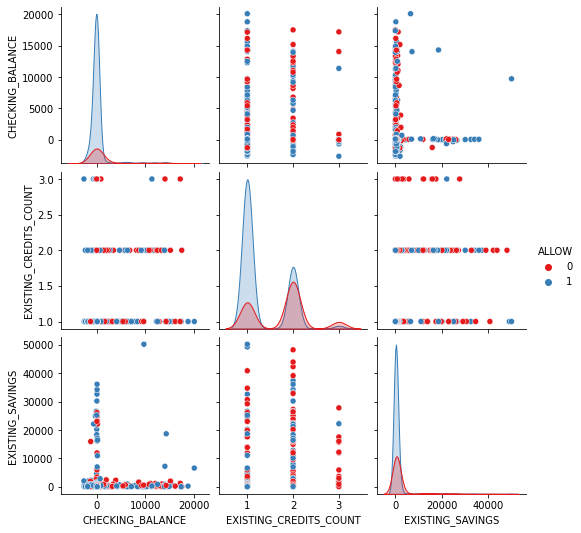

In [22]:
sns.pairplot(df_train_processed[set(account_cols + [target])], hue=target, palette='Set1')
plt.show()

#### Variáveis sobre dados demográficos

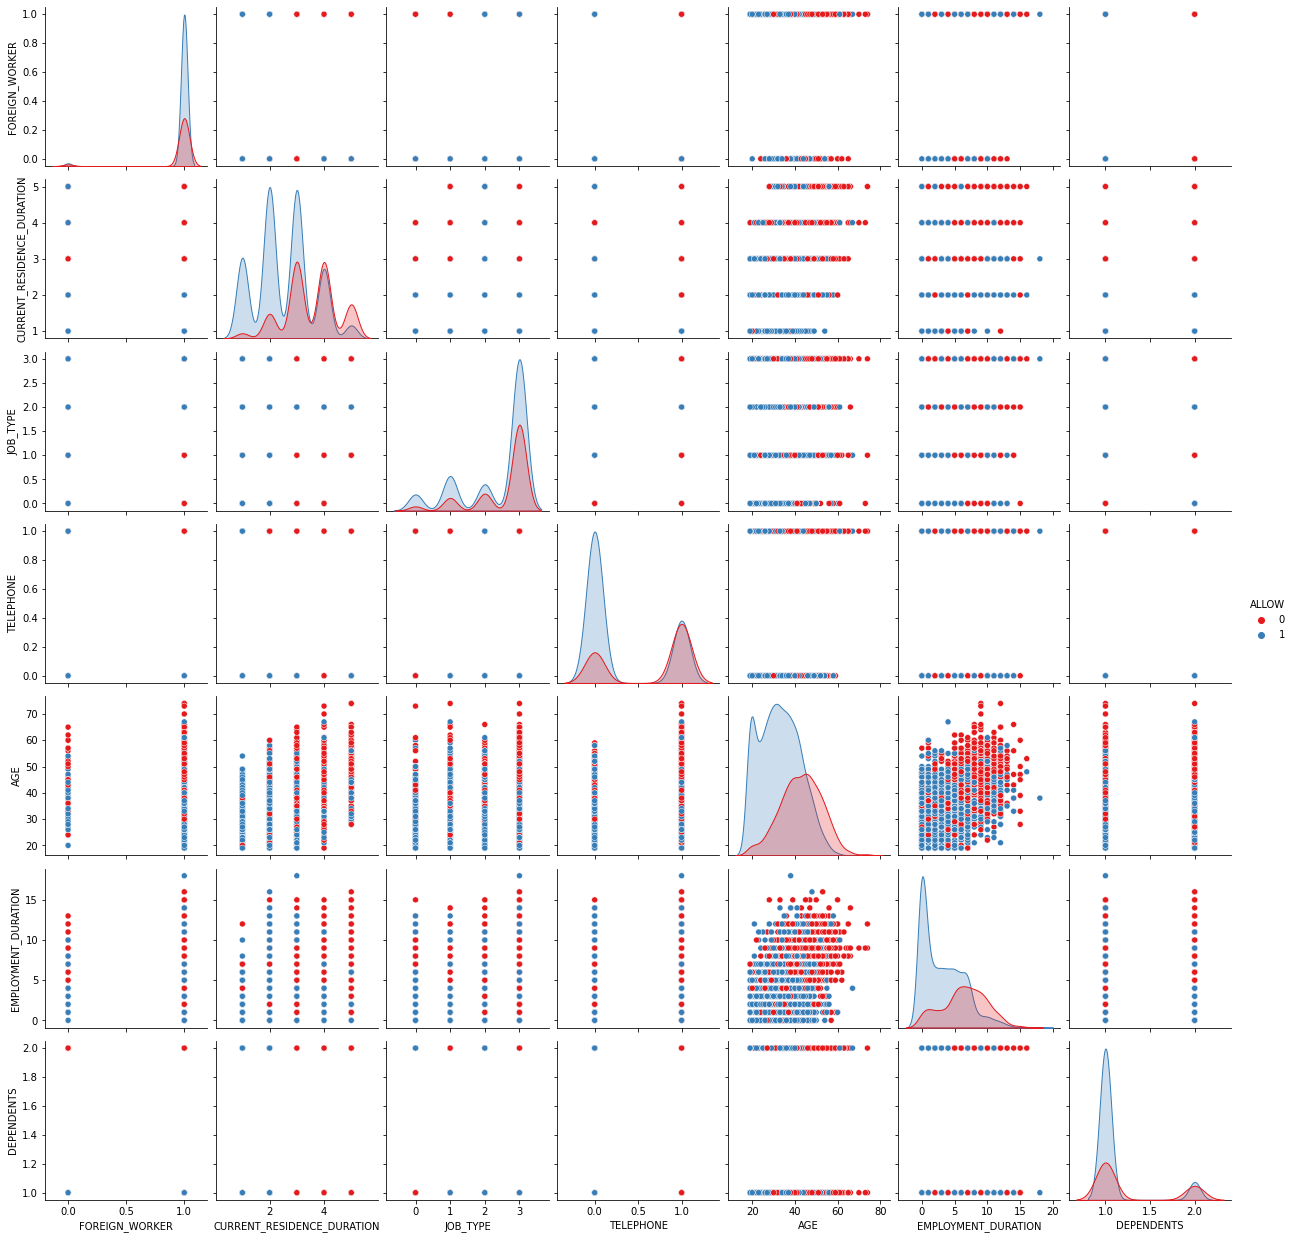

In [23]:
sns.pairplot(df_train_processed[set(demographic_cols + [target])], hue=target, palette='Set1')
plt.show()

- Talvez seja melhor considerar que o tipo de trabalho (`JOB_TYPE`) é uma variável categórica e fazer One-Hot-Encoding, assumindo que não exista necessariamente uma ordenação natural dos tipos

#### Variáveis sobre os empéstimos

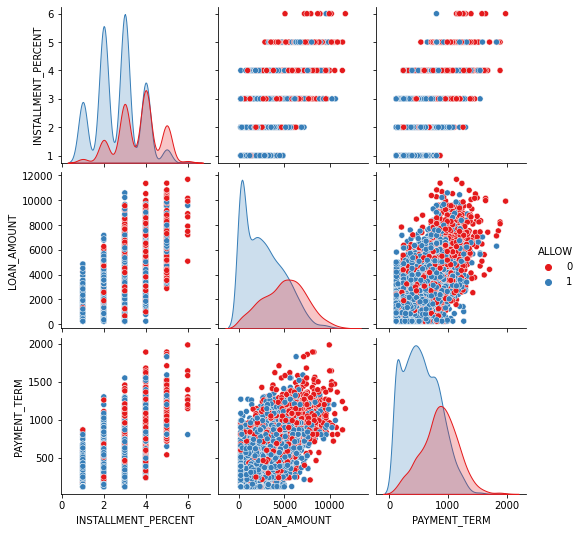

In [24]:
sns.pairplot(df_train_processed[set(loan_cols + [target])], hue=target, palette='Set1')
plt.show()

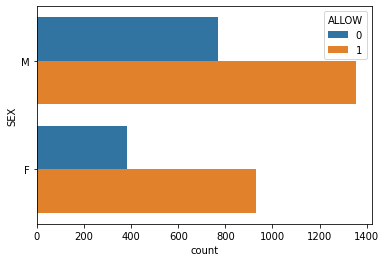

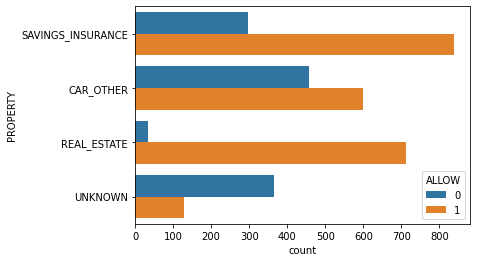

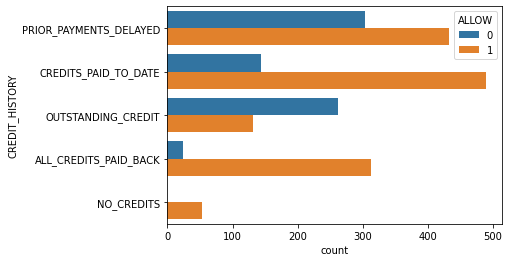

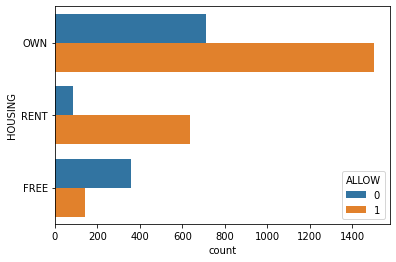

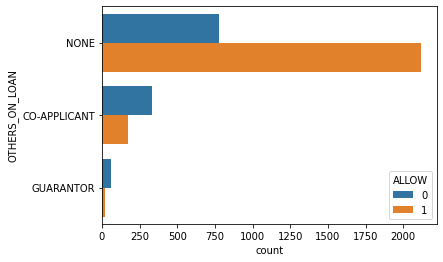

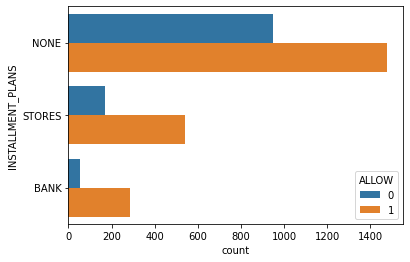

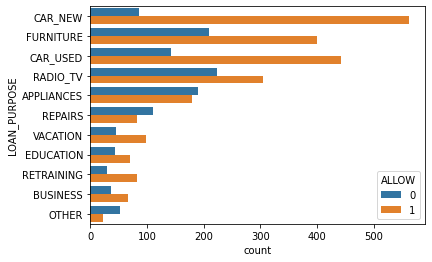

In [25]:
for col in set(non_numeric_cols) - set(possibly_numeric_cols):
    risk_plot = sns.countplot(
        data=df_train, y=col, order=df_train[col].value_counts().index, orient='h', hue='ALLOW'
    )
    plt.show()

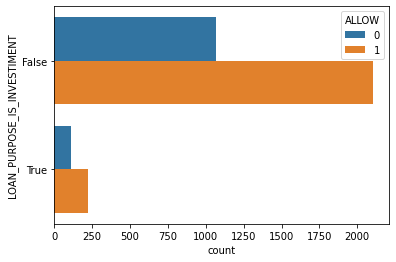

In [26]:
temp = pd.concat(
    [df_train_processed, df_train_processed['LOAN_PURPOSE'].isin(['EDUCATION', 'RETRAINING', 'BUSINESS']).rename('LOAN_PURPOSE_IS_INVESTIMENT')],
    axis=1
)
risk_plot = sns.countplot(
    data=temp, y='LOAN_PURPOSE_IS_INVESTIMENT', order=temp['LOAN_PURPOSE_IS_INVESTIMENT'].value_counts().index, orient='h', hue='ALLOW'
)
plt.show()

## Tratamento dos dados

Uma vez que exploramos os dados, entendemos a importância de cada coluna e podemos fazer alterações nelas para para obter um melhor resultado. Aqui, vamos fazer apenas um tratamento simples, de remover do dataset as linhas que tiverem faltando algum valor. Não necessariamente essa técnica é a melhor para se utilizar no desafio, é apenas um exemplo de como tratar o dataset.

Para tratamentos mais avançados, como modificação de colunas ou criação de novas colunas, veja mais abaixo no Notebook, em que explicamos como utilizar as `Pipelines`, da biblioteca `sklearn`, para realizar transformações nos dados.

In [27]:
clean_df = df_train.dropna()
clean_df.count()


CHECKING_BALANCE              1963
CREDIT_HISTORY                1963
EXISTING_SAVINGS              1963
EXISTING_CREDITS_COUNT        1963
SEX                           1963
AGE                           1963
JOB_TYPE                      1963
DEPENDENTS                    1963
TELEPHONE                     1963
FOREIGN_WORKER                1963
EMPLOYMENT_DURATION           1963
PROPERTY                      1963
HOUSING                       1963
CURRENT_RESIDENCE_DURATION    1963
PAYMENT_TERM                  1963
INSTALLMENT_PLANS             1963
INSTALLMENT_PERCENT           1963
LOAN_PURPOSE                  1963
LOAN_AMOUNT                   1963
OTHERS_ON_LOAN                1963
ALLOW                         1963
dtype: int64

Podemos observar que agora temos um dataset "limpo", mas perdemos alguns dados por remover as linhas em que pelo menos uma coluna estava faltando.

Observando a execução do método `.info()` acima, podemos ver que existem três colunas do tipo `object`. O modelo do `scikit-learn` que vamos usar não é capaz de processar uma variável desse tipo. Portanto, para dar seguimento ao experimento, vamos remover essa coluna. Recomendamos que você use alguma técnica para tratamento de variáveis categóricas, como o _one-hot encoding_, em vez de remover a coluna.

Vamos também remover a coluna `ID`, pois sabemos que ela não é uma informação útil para a predição (é apenas um número identificando um cliente).

In [28]:
object_columns = ["INSTALLMENT_PLANS", "LOAN_PURPOSE", "OTHERS_ON_LOAN"]
clean_df = clean_df.drop(object_columns, axis=1)
# clean_df = clean_df.drop("ID", axis=1)


In [29]:
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 796440 to 136433
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CHECKING_BALANCE            1963 non-null   object 
 1   CREDIT_HISTORY              1963 non-null   object 
 2   EXISTING_SAVINGS            1963 non-null   object 
 3   EXISTING_CREDITS_COUNT      1963 non-null   float64
 4   SEX                         1963 non-null   object 
 5   AGE                         1963 non-null   float64
 6   JOB_TYPE                    1963 non-null   float64
 7   DEPENDENTS                  1963 non-null   float64
 8   TELEPHONE                   1963 non-null   float64
 9   FOREIGN_WORKER              1963 non-null   float64
 10  EMPLOYMENT_DURATION         1963 non-null   float64
 11  PROPERTY                    1963 non-null   object 
 12  HOUSING                     1963 non-null   object 
 13  CURRENT_RESIDENCE_DURATION

## Criação do modelo

Com os dados prontos, podemos selecionar um modelo de Machine Learning para treinar com nossos dados. Nesse exemplo, vamos utilizar um modelo de classificação básico, o de Árvore de Decisão.

Para conseguir avaliar o desempenho do nosso modelo, vamos dividir os dados que temos entre dados de treino e de teste, e assim, após o treinamento, verificar como ele está se saindo com as predições.

Abaixo, separamos os dados que queremos predizer dos dados que utilizamos como informações para a predição.

In [30]:
# features = ["PAYMENT_TERM", "INSTALLMENT_PERCENT", "LOAN_AMOUNT"]
features = ["EXISTING_CREDITS_COUNT", "AGE", "JOB_TYPE", "DEPENDENTS", "TELEPHONE", "FOREIGN_WORKER",
            "EMPLOYMENT_DURATION", "CURRENT_RESIDENCE_DURATION","PAYMENT_TERM", "INSTALLMENT_PERCENT", "LOAN_AMOUNT"]
# target = ["ALLOW"]

X = clean_df[features]
y = clean_df[target]


In [31]:
test_pct = 0.3  # Separaremos 30% dos dados para testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=seed, stratify=y)

model = DecisionTreeClassifier(random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(
    f"Acurácia do modelo (número de predições assertivas sobre número total de testes): {acc}"
)


Acurácia do modelo (número de predições assertivas sobre número total de testes): 0.7096774193548387


Fica como tarefa para você unir os outros conjuntos de dados disponíveis e utilizá-los também para predições no modelo, em vez de remover as colunas.

## Criação de Pipelines no scikit-learn

Para criar um modelo capaz de fazer transformações nos dados de entrada, vamos criar uma `Pipeline` do `scikit-learn` e aplicar nossas transformações dentro dos estágios dela.

Abaixo, definimos um transformador exemplo, que irá remover as colunas passadas como parâmetro em sua inicialização:

In [32]:



# Um transformador para remover colunas indesejadas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Primeiro realizamos a cópia do DataFrame 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis="columns")


Tanto o método `fit` quanto o `transform` devem obrigatoriamente ser definidos, mesmo se não forem fazer nada de diferente, como no caso do `fit` acima.

Da mesma forma, você pode criar outros transformadores, para outros propósitos, sempre herdando das classes `BaseEstimator` e `TransformerMixin`. Você pode utilizar um transformador para, por exemplo, criar novas colunas, editar tipos de dados de colunas existentes, entre outros.

Agora, vamos criar uma Pipeline para utilização do nosso modelo, aceitando todas as colunas esperadas pelo desafio e removendo as que não queremos usar.

In [33]:
challenge_columns = [
    "ID",
    "CHECKING_BALANCE",
    "PAYMENT_TERM",
    "CREDIT_HISTORY",
    "LOAN_PURPOSE",
    "LOAN_AMOUNT",
    "EXISTING_SAVINGS",
    "EMPLOYMENT_DURATION",
    "INSTALLMENT_PERCENT",
    "SEX",
    "OTHERS_ON_LOAN",
    "CURRENT_RESIDENCE_DURATION",
    "PROPERTY",
    "AGE",
    "INSTALLMENT_PLANS",
    "HOUSING",
    "EXISTING_CREDITS_COUNT",
    "JOB_TYPE",
    "DEPENDENTS",
    "TELEPHONE",
    "FOREIGN_WORKER",
    "ALLOW",
]

unwanted_columns = list(
    (set(challenge_columns) - set(target)) - set(features)
)  # Remover todas as colunas que não são features do nosso modelo


In [34]:
# Criando uma instância do transformador, passando como parâmetro as colunas que não queremos
drop_columns = DropColumns(unwanted_columns)


# Criando a Pipeline, adicionando o nosso transformador seguido de um modelo de árvore de decisão
skl_pipeline = Pipeline(
    steps=[("drop_columns", drop_columns), ("classification", model)]
)


Pronto! Essa pipeline agora está pronta para receber todas as variáveis do desafio, apesar de o modelo só usar algumas.